# Big Data Analysis Project
## Comprehensive Data Analysis on Large Synthetic Dataset

This notebook performs in-depth analysis on a large synthetic dataset to demonstrate data exploration, preprocessing, statistical analysis, and visualization techniques.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Generate or Load a Large Random Dataset

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate large synthetic dataset (1 million rows, 15 features)
n_rows = 1_000_000
n_features = 15

print(f"Generating synthetic dataset with {n_rows:,} rows and {n_features} features...")

# Create feature data
data = {
    'customer_id': np.arange(1, n_rows + 1),
    'age': np.random.normal(35, 15, n_rows).astype(int),
    'income': np.random.normal(75000, 30000, n_rows),
    'purchase_amount': np.random.exponential(150, n_rows),
    'transaction_count': np.random.poisson(5, n_rows),
    'customer_lifetime_value': np.random.gamma(2, 500, n_rows),
    'days_since_last_purchase': np.random.exponential(30, n_rows).astype(int),
    'product_category_id': np.random.randint(1, 10, n_rows),
    'customer_satisfaction': np.random.uniform(1, 5, n_rows),
    'product_rating': np.random.uniform(1, 5, n_rows),
    'discount_applied': np.random.binomial(1, 0.3, n_rows),
    'is_returning_customer': np.random.binomial(1, 0.4, n_rows),
    'marketing_spend': np.random.exponential(50, n_rows),
    'region_id': np.random.randint(1, 5, n_rows),
    'seasonality_index': np.random.uniform(0.5, 1.5, n_rows)
}

# Create DataFrame
df = pd.DataFrame(data)

# Introduce some missing values randomly (5% missing)
missing_percentage = 0.05
missing_indices = np.random.choice(df.index, int(len(df) * missing_percentage), replace=False)
df.loc[missing_indices[:len(missing_indices)//2], 'income'] = np.nan
df.loc[missing_indices[len(missing_indices)//2:], 'customer_satisfaction'] = np.nan

# Add some duplicate rows (1% duplicates)
duplicates = df.sample(frac=0.01, random_state=42)
df = pd.concat([df, duplicates], ignore_index=True)

print(f"\nDataset created successfully!")
print(f"Shape: {df.shape}")
print(f"Total rows: {len(df):,}")
print(f"Missing values introduced: ~5%")
print(f"Duplicate rows introduced: ~1%")

Generating synthetic dataset with 1,000,000 rows and 15 features...

Dataset created successfully!
Shape: (1010000, 15)
Total rows: 1,010,000
Missing values introduced: ~5%
Duplicate rows introduced: ~1%


## 3. Explore Dataset Structure and Statistics

In [3]:
print("=" * 80)
print("DATASET STRUCTURE")
print("=" * 80)

print("\nDataFrame Info:")
print(df.info())

print("\n\nFirst 5 rows:")
print(df.head())

print("\n\nDataset Shape:", df.shape)
print("Total Rows:", f"{len(df):,}")
print("Total Columns:", df.shape[1])

print("\n\nData Types:")
print(df.dtypes)

print("\n\nMissing Values Analysis:")
missing_data = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_data[missing_data['Missing Count'] > 0])

print("\n\nBasic Statistical Summary:")
print(df.describe().round(3))

DATASET STRUCTURE

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010000 entries, 0 to 1009999
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   customer_id               1010000 non-null  int64  
 1   age                       1010000 non-null  int64  
 2   income                    984768 non-null   float64
 3   purchase_amount           1010000 non-null  float64
 4   transaction_count         1010000 non-null  int32  
 5   customer_lifetime_value   1010000 non-null  float64
 6   days_since_last_purchase  1010000 non-null  int64  
 7   product_category_id       1010000 non-null  int32  
 8   customer_satisfaction     984745 non-null   float64
 9   product_rating            1010000 non-null  float64
 10  discount_applied          1010000 non-null  int32  
 11  is_returning_customer     1010000 non-null  int32  
 12  marketing_spend           1010000 non-null  float

## 4. Data Cleaning and Preprocessing

In [4]:
print("BEFORE CLEANING:")
print(f"Rows: {len(df):,}, Duplicates: {df.duplicated().sum()}")
print(f"Missing values:\n{df.isnull().sum().sum()}")

# Step 1: Remove duplicates
df_clean = df.drop_duplicates().reset_index(drop=True)
print(f"\nAFTER REMOVING DUPLICATES:")
print(f"Rows: {len(df_clean):,}")

# Step 2: Handle missing values
# For numerical columns, fill with median
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['float64', 'int64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"\nAFTER HANDLING MISSING VALUES:")
print(f"Total missing values: {df_clean.isnull().sum().sum()}")

# Step 3: Data type conversions
df_clean['age'] = df_clean['age'].astype('int64')
df_clean['transaction_count'] = df_clean['transaction_count'].astype('int64')
df_clean['days_since_last_purchase'] = df_clean['days_since_last_purchase'].astype('int64')
df_clean['discount_applied'] = df_clean['discount_applied'].astype('bool')
df_clean['is_returning_customer'] = df_clean['is_returning_customer'].astype('bool')

print(f"\nAFTER DATA TYPE CONVERSION:")
print(df_clean.dtypes)

# Step 4: Remove outliers using IQR method for key numerical columns
numeric_cols = ['age', 'income', 'purchase_amount', 'customer_satisfaction']
print("\n\nOUTLIER DETECTION (IQR METHOD):")
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    print(f"{col}: {outliers:,} outliers detected")

# Keep outliers for now as they may be meaningful in business context
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")

BEFORE CLEANING:
Rows: 1,010,000, Duplicates: 10000
Missing values:
50487

AFTER REMOVING DUPLICATES:
Rows: 1,000,000

AFTER HANDLING MISSING VALUES:
Total missing values: 0

AFTER DATA TYPE CONVERSION:
customer_id                   int64
age                           int64
income                      float64
purchase_amount             float64
transaction_count             int64
customer_lifetime_value     float64
days_since_last_purchase      int64
product_category_id           int32
customer_satisfaction       float64
product_rating              float64
discount_applied               bool
is_returning_customer          bool
marketing_spend             float64
region_id                     int32
seasonality_index           float64
dtype: object


OUTLIER DETECTION (IQR METHOD):
age: 4,658 outliers detected
income: 8,836 outliers detected
purchase_amount: 48,501 outliers detected
customer_satisfaction: 0 outliers detected

Final cleaned dataset shape: (1000000, 15)


## 5. Exploratory Data Analysis (EDA)

In [5]:
print("=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Univariate Analysis
print("\n\nKEY STATISTICS BY COLUMN:")
print("\nAge Distribution:")
print(f"  Mean: {df_clean['age'].mean():.2f}")
print(f"  Median: {df_clean['age'].median():.2f}")
print(f"  Std Dev: {df_clean['age'].std():.2f}")
print(f"  Range: {df_clean['age'].min()} - {df_clean['age'].max()}")

print("\nIncome Distribution:")
print(f"  Mean: ${df_clean['income'].mean():,.2f}")
print(f"  Median: ${df_clean['income'].median():,.2f}")
print(f"  Std Dev: ${df_clean['income'].std():,.2f}")

print("\nPurchase Amount Distribution:")
print(f"  Mean: ${df_clean['purchase_amount'].mean():.2f}")
print(f"  Median: ${df_clean['purchase_amount'].median():.2f}")
print(f"  Std Dev: ${df_clean['purchase_amount'].std():.2f}")

# Categorical Analysis
print("\n\nCATEGORICAL DATA DISTRIBUTIONS:")
print("\nProduct Category Distribution:")
print(df_clean['product_category_id'].value_counts().sort_index())

print("\nRegion Distribution:")
print(df_clean['region_id'].value_counts().sort_index())

print("\nBoolean Features:")
print(f"Discount Applied: {df_clean['discount_applied'].sum():,} (True) out of {len(df_clean):,}")
print(f"Returning Customers: {df_clean['is_returning_customer'].sum():,} (True) out of {len(df_clean):,}")

# Distribution insights
print("\n\nDISTRIBUTION ANALYSIS:")
print("\nSkewness (>0 = right skewed, <0 = left skewed):")
print(f"  Age: {stats.skew(df_clean['age']):.3f}")
print(f"  Income: {stats.skew(df_clean['income']):.3f}")
print(f"  Purchase Amount: {stats.skew(df_clean['purchase_amount']):.3f}")
print(f"  Customer Lifetime Value: {stats.skew(df_clean['customer_lifetime_value']):.3f}")

EXPLORATORY DATA ANALYSIS


KEY STATISTICS BY COLUMN:

Age Distribution:
  Mean: 34.49
  Median: 34.00
  Std Dev: 14.98
  Range: -37 - 105

Income Distribution:
  Mean: $74,996.27
  Median: $75,005.58
  Std Dev: $29,657.59

Purchase Amount Distribution:
  Mean: $150.00
  Median: $104.02
  Std Dev: $149.89


CATEGORICAL DATA DISTRIBUTIONS:

Product Category Distribution:
product_category_id
1    110679
2    111047
3    110755
4    111419
5    111338
6    111189
7    111076
8    110952
9    111545
Name: count, dtype: int64

Region Distribution:
region_id
1    251066
2    249005
3    249854
4    250075
Name: count, dtype: int64

Boolean Features:
Discount Applied: 300,118 (True) out of 1,000,000
Returning Customers: 399,763 (True) out of 1,000,000


DISTRIBUTION ANALYSIS:

Skewness (>0 = right skewed, <0 = left skewed):
  Age: 0.011
  Income: -0.000
  Purchase Amount: 1.983
  Customer Lifetime Value: 1.409


## 6. Statistical Analysis and Correlation

In [6]:
print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numerical columns for correlation
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numerical_cols].corr()

print("\n\nCORRELATION MATRIX (Top 15 Features):")
print(correlation_matrix.iloc[:15, :15].round(3))

# Find strongest correlations
print("\n\nSTRONGEST CORRELATIONS (excluding self-correlation):")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], abs(corr_value)))

corr_pairs.sort(key=lambda x: x[2], reverse=True)
for col1, col2, corr in corr_pairs[:10]:
    print(f"  {col1} <-> {col2}: {corr:.4f}")

# Hypothesis Testing: T-test for income based on discount
print("\n\nHYPOTHESIS TESTING:")
print("\nT-test: Income difference between customers with and without discount")
with_discount = df_clean[df_clean['discount_applied'] == True]['income']
without_discount = df_clean[df_clean['discount_applied'] == False]['income']
t_stat, p_value = stats.ttest_ind(with_discount, without_discount)
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Mean income (with discount): ${with_discount.mean():,.2f}")
print(f"  Mean income (without discount): ${without_discount.mean():,.2f}")
if p_value < 0.05:
    print("  Result: SIGNIFICANT difference (p < 0.05)")
else:
    print("  Result: NO significant difference (p >= 0.05)")

# Chi-square test for categorical relationship
print("\n\nChi-Square Test: Discount Application vs Returning Customer Status")
contingency_table = pd.crosstab(df_clean['discount_applied'], df_clean['is_returning_customer'])
chi2, p_value_chi, dof, expected = stats.chi2_contingency(contingency_table)
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  P-value: {p_value_chi:.6f}")
print(f"  Contingency Table:\n{contingency_table}")
if p_value_chi < 0.05:
    print("  Result: SIGNIFICANT relationship (p < 0.05)")
else:
    print("  Result: NO significant relationship (p >= 0.05)")

CORRELATION ANALYSIS


CORRELATION MATRIX (Top 15 Features):
                          customer_id    age  income  purchase_amount  \
customer_id                     1.000 -0.002   0.001            0.000   
age                            -0.002  1.000   0.001            0.002   
income                          0.001  0.001   1.000           -0.001   
purchase_amount                 0.000  0.002  -0.001            1.000   
transaction_count               0.001 -0.000  -0.001           -0.000   
customer_lifetime_value         0.001  0.000  -0.001            0.001   
days_since_last_purchase       -0.000  0.002   0.002           -0.001   
product_category_id             0.001 -0.002  -0.000            0.000   
customer_satisfaction          -0.000  0.001  -0.000            0.000   
product_rating                  0.000 -0.000   0.001           -0.001   
marketing_spend                 0.002  0.000   0.001           -0.001   
region_id                       0.002  0.001   0.001           

## 7. Data Visualization

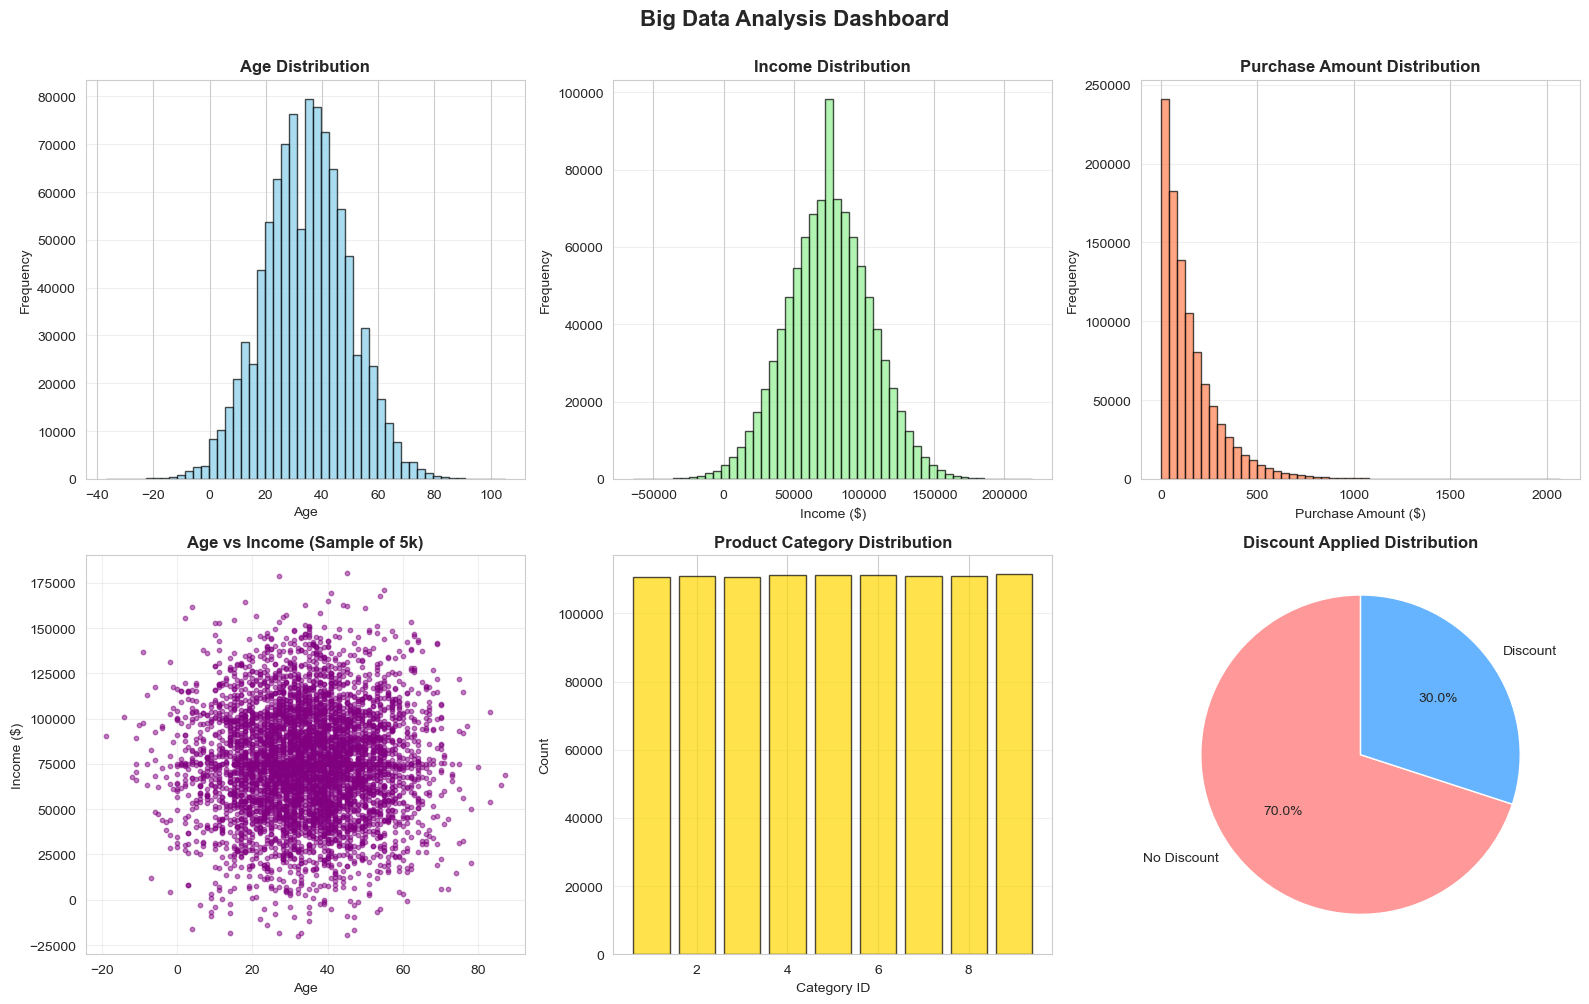

Dashboard visualization created successfully!


In [7]:
# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Big Data Analysis Dashboard', fontsize=16, fontweight='bold', y=1.00)

# 1. Age Distribution
axes[0, 0].hist(df_clean['age'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Age Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Income Distribution
axes[0, 1].hist(df_clean['income'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Income Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Income ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Purchase Amount Distribution
axes[0, 2].hist(df_clean['purchase_amount'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Purchase Amount Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Purchase Amount ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Scatter: Age vs Income
axes[1, 0].scatter(df_clean['age'].sample(5000), df_clean['income'].sample(5000), 
                   alpha=0.5, s=10, color='purple')
axes[1, 0].set_title('Age vs Income (Sample of 5k)', fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Income ($)')
axes[1, 0].grid(alpha=0.3)

# 5. Product Category Distribution
category_counts = df_clean['product_category_id'].value_counts().sort_index()
axes[1, 1].bar(category_counts.index, category_counts.values, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Product Category Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Category ID')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Discount Applied vs No Discount
discount_counts = df_clean['discount_applied'].value_counts()
colors = ['#ff9999', '#66b3ff']
axes[1, 2].pie(discount_counts.values, labels=['No Discount', 'Discount'], autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[1, 2].set_title('Discount Applied Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print("Dashboard visualization created successfully!")

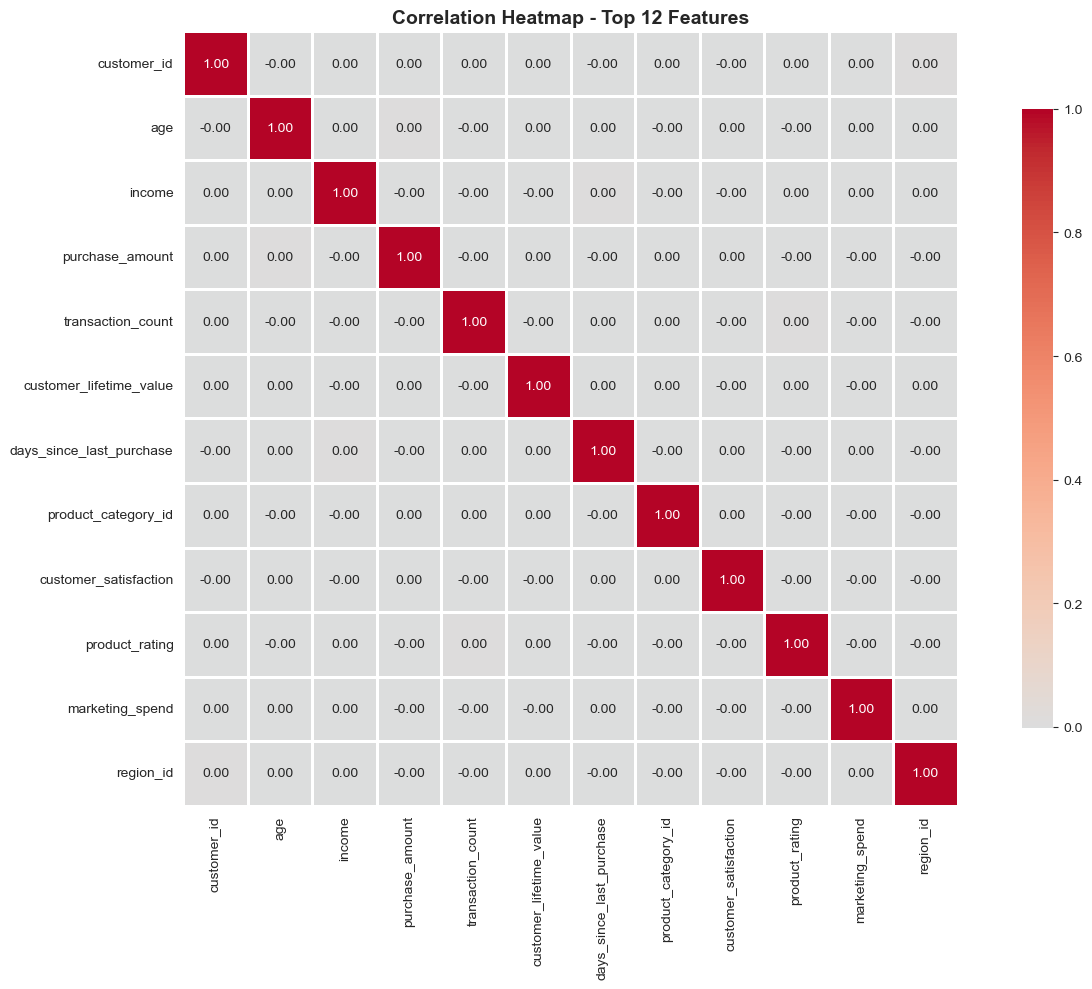

Correlation heatmap created successfully!


In [8]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(correlation_matrix.iloc[:12, :12], annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Heatmap - Top 12 Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("Correlation heatmap created successfully!")

## 8. Aggregation and Grouping

AGGREGATION AND GROUPING ANALYSIS


AVERAGE METRICS BY PRODUCT CATEGORY:
                    purchase_amount                 customer_satisfaction  \
                               mean  median   count                  mean   
product_category_id                                                         
1                            150.00  103.84  110679                  3.00   
2                            149.94  104.21  111047                  2.99   
3                            150.00  104.66  110755                  3.00   
4                            149.94  104.03  111419                  3.00   
5                            150.01  103.58  111338                  3.00   
6                            150.54  104.10  111189                  3.00   
7                            149.69  104.11  111076                  3.01   
8                            149.55  103.63  110952                  3.00   
9                            150.34  104.02  111545                  3.00   

  

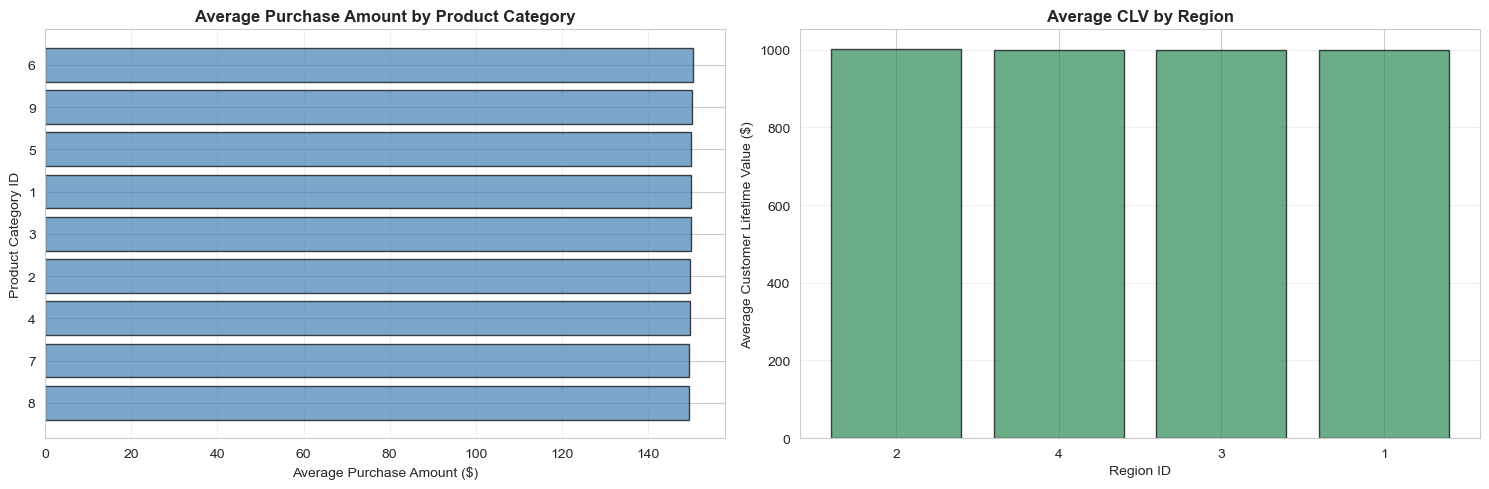

In [9]:
print("=" * 80)
print("AGGREGATION AND GROUPING ANALYSIS")
print("=" * 80)

# Group by Product Category
print("\n\nAVERAGE METRICS BY PRODUCT CATEGORY:")
category_analysis = df_clean.groupby('product_category_id').agg({
    'purchase_amount': ['mean', 'median', 'count'],
    'customer_satisfaction': 'mean',
    'income': 'mean',
    'customer_lifetime_value': 'mean'
}).round(2)
print(category_analysis)

# Group by Region
print("\n\nAVERAGE METRICS BY REGION:")
region_analysis = df_clean.groupby('region_id').agg({
    'purchase_amount': ['mean', 'sum'],
    'transaction_count': 'mean',
    'customer_lifetime_value': 'mean',
    'marketing_spend': 'mean'
}).round(2)
print(region_analysis)

# Customer Segmentation by Returning Status
print("\n\nCUSTOMER SEGMENTATION - RETURNING vs NEW:")
customer_segment = df_clean.groupby('is_returning_customer').agg({
    'purchase_amount': ['mean', 'std'],
    'income': 'mean',
    'customer_lifetime_value': 'mean',
    'customer_id': 'count',
    'discount_applied': lambda x: (x.sum() / len(x) * 100)
}).round(2)
customer_segment.columns = ['Avg Purchase', 'Std Purchase', 'Avg Income', 'Avg CLV', 'Count', 'Discount %']
print(customer_segment)

# Age Group Analysis
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 20, 30, 40, 50, 60, 100], 
                               labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])
print("\n\nAGE GROUP ANALYSIS:")
age_group_analysis = df_clean.groupby('age_group').agg({
    'purchase_amount': 'mean',
    'income': 'mean',
    'customer_satisfaction': 'mean',
    'customer_id': 'count'
}).round(2)
age_group_analysis.columns = ['Avg Purchase', 'Avg Income', 'Satisfaction', 'Count']
print(age_group_analysis)

# Visualization of aggregated data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average Purchase by Category
category_avg = df_clean.groupby('product_category_id')['purchase_amount'].mean().sort_values()
axes[0].barh(category_avg.index.astype(str), category_avg.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Average Purchase Amount ($)')
axes[0].set_ylabel('Product Category ID')
axes[0].set_title('Average Purchase Amount by Product Category', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Average CLV by Region
region_avg_clv = df_clean.groupby('region_id')['customer_lifetime_value'].mean().sort_values(ascending=False)
axes[1].bar(region_avg_clv.index.astype(str), region_avg_clv.values, color='seagreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Region ID')
axes[1].set_ylabel('Average Customer Lifetime Value ($)')
axes[1].set_title('Average CLV by Region', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Performance Optimization and Sampling

In [10]:
import time

print("=" * 80)
print("PERFORMANCE OPTIMIZATION AND SAMPLING")
print("=" * 80)

# Memory optimization
print("\n\nMEMORY USAGE:")
print(f"Total DataFrame memory: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Memory per row: {(df_clean.memory_usage(deep=True).sum() / len(df_clean)):.2f} bytes")

# Data type optimization
print("\n\nDATA TYPE OPTIMIZATION:")
print("Current dtypes:")
print(df_clean.dtypes)

# Downcast to more memory-efficient types
df_optimized = df_clean.copy()
df_optimized['age'] = df_optimized['age'].astype('int16')
df_optimized['transaction_count'] = df_optimized['transaction_count'].astype('int16')
df_optimized['product_category_id'] = df_optimized['product_category_id'].astype('int8')
df_optimized['region_id'] = df_optimized['region_id'].astype('int8')

print(f"\nOptimized memory usage: {df_optimized.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Memory saved: {((1 - df_optimized.memory_usage(deep=True).sum() / df_clean.memory_usage(deep=True).sum()) * 100):.1f}%")

# Sampling strategies
print("\n\nSAMPLING STRATEGIES FOR LARGE DATASETS:")

# Random Sampling
print("\n1. RANDOM SAMPLING (10% of data):")
sample_10pct = df_clean.sample(frac=0.1, random_state=42)
print(f"   Sample size: {len(sample_10pct):,} rows")
print(f"   Mean income (full): ${df_clean['income'].mean():,.2f}")
print(f"   Mean income (sample): ${sample_10pct['income'].mean():,.2f}")
print(f"   Difference: ${abs(df_clean['income'].mean() - sample_10pct['income'].mean()):,.2f}")

# Stratified Sampling
print("\n2. STRATIFIED SAMPLING (by region):")
stratified_list = []
for region in df_clean['region_id'].unique():
    region_data = df_clean[df_clean['region_id'] == region]
    stratified_list.append(region_data.sample(frac=0.05, random_state=42))
stratified_sample = pd.concat(stratified_list, ignore_index=True)
print(f"   Sample size: {len(stratified_sample):,} rows")
print(f"   Distribution by region:")
print(stratified_sample['region_id'].value_counts().sort_index())

# Systematic Sampling
print("\n3. SYSTEMATIC SAMPLING (every 100th row):")
systematic_sample = df_clean.iloc[::100]
print(f"   Sample size: {len(systematic_sample):,} rows")

# Performance comparison
print("\n\nPERFORMANCE COMPARISON - AGGREGATION OPERATIONS:")
print("(Measuring execution time)")

# Full dataset operation
start = time.time()
full_result = df_clean.groupby('region_id')['purchase_amount'].mean()
full_time = time.time() - start

# Sample operation
start = time.time()
sample_result = sample_10pct.groupby('region_id')['purchase_amount'].mean()
sample_time = time.time() - start

print(f"Full dataset aggregation: {full_time*1000:.2f} ms")
print(f"10% sample aggregation: {sample_time*1000:.2f} ms")
print(f"Speedup: {full_time/sample_time:.1f}x faster with sampling")
print(f"Results are comparable: Correlation = {full_result.corr(sample_result):.4f}")

# Summary
print("\n\n" + "=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nOriginal dataset rows: {len(df):,}")
print(f"Cleaned dataset rows: {len(df_clean):,}")
print(f"Total features analyzed: {df_clean.shape[1]}")
print(f"\nSignificant findings:")
print(f"  - Average customer lifetime value: ${df_clean['customer_lifetime_value'].mean():,.2f}")
print(f"  - Discount penetration: {(df_clean['discount_applied'].sum() / len(df_clean) * 100):.1f}%")
print(f"  - Customer satisfaction average: {df_clean['customer_satisfaction'].mean():.2f}/5.0")
print(f"  - Average purchase amount: ${df_clean['purchase_amount'].mean():.2f}")
print(f"  - Data quality: {((1 - df_clean.isnull().sum().sum() / (len(df_clean) * df_clean.shape[1])) * 100):.2f}% complete")
print("\n" + "=" * 80)

PERFORMANCE OPTIMIZATION AND SAMPLING


MEMORY USAGE:
Total DataFrame memory: 94.41 MB
Memory per row: 99.00 bytes


DATA TYPE OPTIMIZATION:
Current dtypes:
customer_id                    int64
age                            int64
income                       float64
purchase_amount              float64
transaction_count              int64
customer_lifetime_value      float64
days_since_last_purchase       int64
product_category_id            int32
customer_satisfaction        float64
product_rating               float64
discount_applied                bool
is_returning_customer           bool
marketing_spend              float64
region_id                      int32
seasonality_index            float64
age_group                   category
dtype: object

Optimized memory usage: 77.25 MB
Memory saved: 18.2%


SAMPLING STRATEGIES FOR LARGE DATASETS:

1. RANDOM SAMPLING (10% of data):
   Sample size: 100,000 rows
   Mean income (full): $74,996.27
   Mean income (sample): $75,133.97
   Diff